In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from torchvision import datasets, transforms

In [2]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
clstr_centers = 10
train_samples = 50000
test_samples = 100
spread = 0.5
rndm_state = 200
bat_size = 32

In [4]:
x_train, y_train = make_blobs(n_samples = train_samples, centers = clstr_centers, cluster_std = spread, random_state = rndm_state)
x_test, y_test = make_blobs(n_samples = test_samples, centers = clstr_centers, cluster_std = spread, random_state = rndm_state)

In [5]:
# x_train = torch.FloatTensor(x_train)
# y_train = torch.FloatTensor(y_train)

In [6]:
print(x_train.shape)
print(y_train.shape)

(50000, 2)
(50000,)


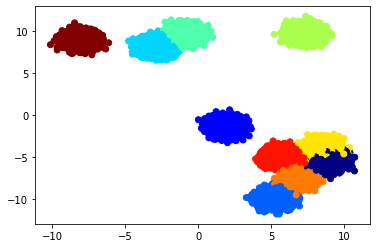

In [7]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')

In [8]:
y_train = np.expand_dims(y_train, axis = 1)

Design_Matrix = np.concatenate((x_train, y_train), axis = 1)
print(Design_Matrix.shape)
np.savetxt('train_data.txt', Design_Matrix, delimiter = '\t')

print(x_train.shape)
print(Design_Matrix.shape[1])

(50000, 3)
(50000, 2)
3


In [9]:
class Dataset_1(torch.utils.data.Dataset):

  def __init__(self, src_file, n_rows = None):
    all_xy = np.loadtxt(src_file, max_rows = n_rows, usecols = np.arange(Design_Matrix.shape[1]), delimiter = '\t', skiprows = 0, comments = "#", dtype = np.float32)
    n = len(all_xy)
    tmp_x = all_xy[0:n, 0:x_train.shape[1]]
    tmp_y = all_xy[0:n, x_train.shape[1]]
    self.x_data = torch.tensor(tmp_x, dtype = torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype = torch.int64)
    
  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    preds = self.x_data[idx]
    trgts = self.y_data[idx]
    sample = {
        'predictors' : preds,
        'targets' : trgts
    }
    return preds, trgts

In [10]:
train_file = '/content/train_data.txt'
train_ds = Dataset_1(train_file, n_rows = train_samples)

In [11]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = bat_size, shuffle = True)

In [12]:
for (X_train, Y_train) in train_loader:
  print("X_train: ", X_train.size(), "Type: ", X_train.type())
  print("Y_train: ", Y_train.size(), "Type: ",Y_train.type())
  break

X_train:  torch.Size([32, 2]) Type:  torch.FloatTensor
Y_train:  torch.Size([32]) Type:  torch.LongTensor


In [13]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 50)
    self.fc2 = nn.Linear(50, 50)
    self.fc3 = nn.Linear(50, 50)
    self.fc4 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return F.log_softmax(self.fc4(x), dim = 1)

In [14]:
model = Net()
# model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

In [15]:
def train(epoch, log_interval = 200):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data#.to(device)
    target = target#.to(device)

    optimizer.zero_grad()

    output = model(data)
    loss = criterion(output, target)

    loss.backward()

    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100 * batch_idx / len(train_loader), loss.data.item()))

In [16]:
%%time
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs + 1):
  train(epoch)

Train: 1 [0/50000 (0%)]	Loss: 2.320618
Train: 1 [6400/50000 (13%)]	Loss: 0.724457
Train: 1 [12800/50000 (26%)]	Loss: 0.442696
Train: 1 [19200/50000 (38%)]	Loss: 0.447054
Train: 1 [25600/50000 (51%)]	Loss: 0.222365
Train: 1 [32000/50000 (64%)]	Loss: 0.341106
Train: 1 [38400/50000 (77%)]	Loss: 0.089865
Train: 1 [44800/50000 (90%)]	Loss: 0.181727
Train: 2 [0/50000 (0%)]	Loss: 0.151440
Train: 2 [6400/50000 (13%)]	Loss: 0.287693
Train: 2 [12800/50000 (26%)]	Loss: 0.103345
Train: 2 [19200/50000 (38%)]	Loss: 0.124699
Train: 2 [25600/50000 (51%)]	Loss: 0.080769
Train: 2 [32000/50000 (64%)]	Loss: 0.113824
Train: 2 [38400/50000 (77%)]	Loss: 0.256785
Train: 2 [44800/50000 (90%)]	Loss: 0.024596
Train: 3 [0/50000 (0%)]	Loss: 0.039328
Train: 3 [6400/50000 (13%)]	Loss: 0.099095
Train: 3 [12800/50000 (26%)]	Loss: 0.176046
Train: 3 [19200/50000 (38%)]	Loss: 0.089971
Train: 3 [25600/50000 (51%)]	Loss: 0.152877
Train: 3 [32000/50000 (64%)]	Loss: 0.037990
Train: 3 [38400/50000 (77%)]	Loss: 0.029270
Train:

In [17]:
x_train.shape

(50000, 2)

xx.shape:  (276, 249)
torch.Size([68724])


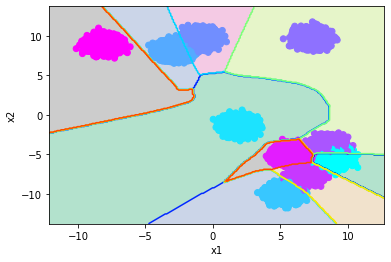

In [20]:
X = x_train
x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print('xx.shape: ', xx.shape)
Xn = (np.c_[xx.ravel(), yy.ravel()])
Xn = torch.FloatTensor(Xn)
P = model(Xn)
P = P.max(1)[1]
PP = P.detach().numpy()
PP = PP.reshape(xx.shape)
print(P.shape)
# t = [10 if y_train[i] == 0 else 1 for i in range(np.shape(y_train)[0])]
plt.contourf(xx, yy, PP, cmap = 'Pastel2')
plt.contour(xx, yy, PP, cmap = 'jet')
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(x_train[:,0], x_train[:,1], c = y_train, cmap = 'cool')